In [108]:
from sklearn.model_selection import GridSearchCV
import gensim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
import embeddingvectorizer
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multiclass import OneVsRestClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier 

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.model_selection import cross_val_score
from collections import defaultdict
from tabulate import tabulate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from nltk.corpus import stopwords
from string import punctuation
import nltk
import pandas as pd
from collections import Counter
from nltk.stem.snowball import SnowballStemmer


In [106]:
OUTPUT_PATH ='../output/'
PATH = '/Users/anne/surfdrive/uva/projects/RPA_KeepingScore/data/RPA_data_with_dictionaryscores.pkl'
PE = '/Users/anne/repos/embedding_models/RPA/w2v_300d2000-01-01_2018-12-31'

In [346]:
print("\nLoading model")
mod = gensim.models.Word2Vec.load(PE)
MDL = dict(zip(mod.wv.index2word, mod.wv.syn0))


Loading model


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [109]:
df = pd.read_pickle(PATH)

In [288]:
documentA = "vader kinderen schuilen jaren in kelder in drenthe".split(" ")
documentB = "laat kinderen jaren gratis met het OV reizen".split(" ")

In [289]:
wordSet = set(documentA).union(set(documentB))

In [290]:
wordDictA= dict.fromkeys(wordSet,0)
wordDictB= dict.fromkeys(wordSet,0)

In [291]:
for word in documentA:
    wordDictA[word]+=1
    
for word in documentB:
    wordDictB[word]+=1

In [292]:
import pandas as pd
pd.DataFrame([wordDictA, wordDictB])

,schuilen,gratis,in,jaren,het,reizen,kinderen,kelder,vader,drenthe,OV,met,laat
0,1,0,2,1,0,0,1,1,1,1,0,0,0
1,0,1,0,1,1,1,1,0,0,0,1,1,1


In [323]:
from sklearn.feature_extraction.text import TfidfVectorizer
mystopwords = stopwords.words('dutch')

cv= TfidfVectorizer(stop_words=mystopwords) 

x = cv.fit_transform(['vader en kinderen schuilen jaren in kelder in drenthe', 
                      'laat kinderen jaren gratis met het ov reizen'   ])

In [ ]:
 'Boerenprotest niet op Binnenhof, Defensie helpt met afzetten centrum Den Haag', 
                      '14-jarige jongen neergestoken in Rotterdam, twee minderjarigen opgepakt',
                       'Waarom pastoor John studenten het graf in jaagt', 
                       'Minder administratie levert in psychiatrie bijna uur per dag op',
                    

In [328]:
final = []
for i in zip(cv.get_feature_names(), x.toarray()[0]):
    #if i[0] in 'vader en kinderen schuilen jaren in kelder in Drenthe':
    final.append(i)
df = pd.DataFrame(final)

In [335]:
final = []
for i in zip(cv.get_feature_names(), x.toarray()[1]):
    #if i[0] in 'vader en kinderen schuilen jaren in kelder in Drenthe':
    final.append(i)
df2 = pd.DataFrame(final)
df2.set_index(0, inplace=True)
df2 = df2.transpose()

In [329]:
df.set_index(0, inplace=True)
df = df.transpose()


,drenthe,gratis,jaren,kelder,kinderen,laat,ov,reizen,schuilen,vader
1,0.446656,0.0,0.3178,0.446656,0.3178,0.0,0.0,0.0,0.446656,0.446656


In [336]:
df_f = pd.concat([df, df2])

In [337]:
df_f 

,drenthe,gratis,jaren,kelder,kinderen,laat,ov,reizen,schuilen,vader
1,0.446656,0.000000,0.3178,0.446656,0.3178,0.000000,0.000000,0.000000,0.446656,0.446656
1,0.000000,0.446656,0.3178,0.000000,0.3178,0.446656,0.446656,0.446656,0.000000,0.000000


In [353]:
d = df.transpose()
d.

,1
0,
drenthe,0.446656
gratis,0.000000
jaren,0.317800
kelder,0.446656
kinderen,0.317800
laat,0.000000
ov,0.000000
reizen,0.000000
schuilen,0.446656


Text(0, 0.5, 'V')

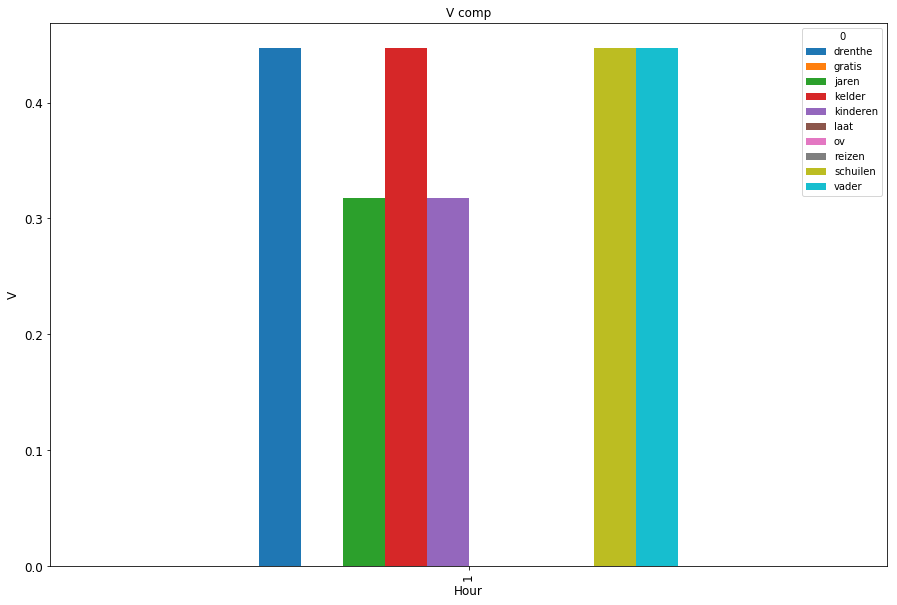

In [367]:
#d = df_f.iloc[0]
import matplotlib.pyplot as plt
ax = df.plot(kind='bar', title ="V comp",figsize=(15,10),legend=True, fontsize=12)
ax.set_xlabel("Hour",fontsize=12)
ax.set_ylabel("V",fontsize=12)

In [246]:
from sklearn.feature_extraction.text import TfidfVectorizer
mystopwords = stopwords.words('dutch')

cv= TfidfVectorizer(stop_words=mystopwords) 
x = cv.fit_transform(['Vader en kinderen schuilen jaren in kelder in Drenthe', 
                      'Laat kinderen tot twaalf jaar gratis met het openbaar vervoer reizen.',
                      'Boerenprotest niet op Binnenhof, Defensie helpt met afzetten centrum Den Haag', 
                      '14-jarige jongen neergestoken in Rotterdam, twee minderjarigen opgepakt',
                       'Waarom pastoor John studenten het graf in jaagt', 
                       'Minder administratie levert in psychiatrie bijna uur per dag op',
                       ])


In [244]:
df = pd.DataFrame([cv.get_feature_names(), x.toarray()[0], x.toarray()[1]])
df.rename(columns=df.iloc[0]).drop(df.index[0])


,14,administratie,afzetten,bijna,binnenhof,boerenprotest,centrum,dag,defensie,den,...,rotterdam,schuilen,studenten,twaalf,twee,uur,vader,vervoer,waarom,zes
1,0,0,0,0,0,0,0,0,0,0,...,0,0.387131,0,0,0,0,0.387131,0,0,0.387131
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.361022,0,0,0,0.361022,0,0


In [146]:
2 * np.log(3/2)


0.8109302162163288

In [54]:
import sys
sys.path.insert(1, '../helpers/')

from prep_annotated_data import *
import numpy as np
import pandas as pd
import logging
import os

# merge annotated data with text from vk and tel

PATH_TO_DATA = '~/surfdrive/uva/projects/RPA_KeepingScore/data/'

PATH_TO_VK = "/Volumes/AnneKroon/RPA/Media data/De Volkskrant/"
files_vk = os.listdir(PATH_TO_VK)

PATH_TO_TEL = "/Volumes/AnneKroon/RPA/Media data/De telegraaf/"
files_tel = os.listdir(PATH_TO_TEL)

print("lets go!")

df = read_and_clean()
print('get cleaned df')

files_xls_vk = [f for f in files_vk if f[-4:] == 'xlsx' and not f.startswith('.') and not f.startswith('~$') ]
files_xls_tel = [f for f in files_tel if f[-4:] == 'xlsx' and not f.startswith('.') and not f.startswith('~$') ]

df_vk = pd.DataFrame()
for f in files_xls_vk:
   # print(f)
    data = pd.read_excel(PATH_TO_VK + f)
    df_vk = df_vk.append(data)

df_tel = pd.DataFrame()
for f in files_xls_tel:
    print(f)
    data = pd.read_excel(PATH_TO_TEL + f)
    df_tel = df_tel.append(data)

df_vk['doc_num'] = df_vk['document nummer'].fillna(0) + df_vk['document numer'].fillna(0) + df_vk['Document nummer'].fillna(0)
df_vk['doc_num'] = pd.to_numeric(df_vk['doc_num'])
df_vk['publication_date'] = df_vk['publication_date'].str[:10]
df_vk['publication_date'] = pd.to_datetime(df_vk.publication_date, format = '%Y-%m-%d', errors="raise")
df_vk['newspaper'] = 'VK'
df_tel['doc_num'] = df_tel['document nummer'].fillna(0) + df_tel['Document nummer'].fillna(0)
df_tel['publication_date'] = df_tel['publication_date'].str[:10]
df_tel['publication_date'] = pd.to_datetime(df_tel.publication_date, format = '%Y-%m-%d', errors="raise")
df_tel['newspaper'] = 'TEL'

df_all = pd.concat([df_vk, df_tel])

lets go!


2019-10-14 13:59:57,102 : INFO : length df BEFORE removing articles without political content: 3603
2019-10-14 13:59:57,127 : INFO : length df AFTER removing without political content: 3250


reading and cleaning dataset ...
get cleaned df


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


TG_2005.xlsx
TG_2013.xlsx
TG_2009.xlsx
TG_1999.xlsx
TG_2008.xlsx
TG_2012.xlsx
TG_2004.xlsx
TG_2003.xlsx
TG_2015.xlsx
TG_2014.xlsx
TG_2002.xlsx
TG_2017.xlsx
TG_2001.xlsx
TG_2000.xlsx
TG_2016.xlsx
TG_2011.xlsx
TG_2007.xlsx
TG_2006.xlsx
TG_2010.xlsx


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [62]:
df = pd.read_pickle(BPATH +'VK_TEL_merged_with_annotated.pkl')
df['doctype'].value_counts()

1113

In [71]:
with open('../resources/topic_translation') as handle:
    translator = json.loads(handle.read()) 

In [79]:
df2 = pd.read_pickle(PATH)

df2['topic_label_en'] = df2['main_topic_label'].replace(translator)

In [103]:
#df2['main_topic_label'].
len(df2)
df2.groupby(['topic_label_en'])['main_topic_label'].max()

topic_label_en
Banking, finance, & commerce    Ondernemingen, Bankwezen en binnenlandse handel 
Civil rights                                          Burgerrechten en vrijheden
Defense                                                                 Defensie
Education                                                              Onderwijs
Environment                                                               Milieu
Governmental operations              Functioneren democratie en openbaar bestuur
Health                                                                Gezondheid
Immigration & integration                               Immigratie en integratie
Int. affairs & foreign aid       Buitenlandse zaken en ontwikkelingssamenwerking
Labor & employment                                                        Arbeid
Law & crime                                 Justitie, Rechtspraak, Criminaliteit
Other issue                                                              Overige
Social welfar

In [102]:
df2.groupby(['topic_label_en'])['topic_label_en'].value_counts()
#d.to_csv('Table.csv')

topic_label_en                topic_label_en              
Banking, finance, & commerce  Banking, finance, & commerce     95
Civil rights                  Civil rights                    166
Defense                       Defense                         125
Education                     Education                        99
Environment                   Environment                     102
Governmental operations       Governmental operations         423
Health                        Health                          262
Immigration & integration     Immigration & integration       125
Int. affairs & foreign aid    Int. affairs & foreign aid      212
Labor & employment            Labor & employment              101
Law & crime                   Law & crime                     284
Other issue                   Other issue                     537
Social welfare                Social welfare                   97
Transportation                Transportation                  179
Name: topic_label

In [5]:
# only keep newspaper data
df = df[df['type'] == 'newspaper']
# define frames
frames = ['attrresp', 'cnflct','ecnmc', 'hmnintrst']

# 2 = not present, set to zero (0 = not present, 1 = present)
df[frames] = df[frames].replace({2:0})
df['attrresp'].fillna(0, inplace=True)
df.rename(columns= {'text_x': 'text'}, inplace=True)

Text(0.5, 0, 'category')

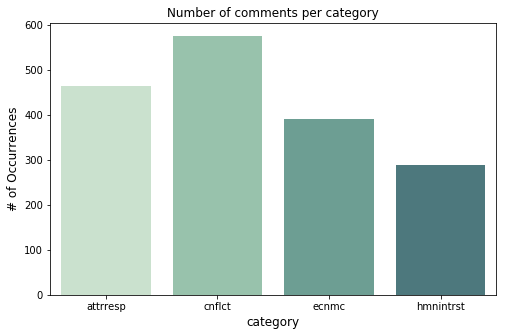

In [4]:
df_ = df[frames]
counts = []
categories = list(df_.columns.values)
for i in categories:
    counts.append((i, df_[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

plt.figure(figsize=(8,5))
ax = sns.barplot(x='category', y='number_of_comments', data=df_stats, palette=sns.cubehelix_palette(rot=-.4))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

In [6]:
rowsums = df_[frames].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values, palette=sns.cubehelix_palette(rot=-.4))
plt.title("Number of frames per news article")
plt.ylabel('# of occurrences', fontsize=16)
plt.xlabel('# of frames', fontsize=16)

NameError: name 'df_' is not defined

In [9]:
train, test = train_test_split(df, random_state=42, test_size=0.3, shuffle=True)

x_train = train.text
x_test = test.text

In [10]:
list(train.columns)

['text',
 'topic',
 'main_topic_label',
 'attrresp',
 'attrresp_wrds',
 'hmnintrst',
 'hmnintrst_wrds',
 'cnflct',
 'cnflct_wrds',
 'ecnmc',
 'ecnmc_wrds',
 'type',
 'origin',
 'documentnr',
 'topic_label_dictionary',
 'index_words',
 'smallest_index',
 'len matches',
 'words matches',
 'text_y',
 'stemmed_topic_label_dictionary',
 'stemmed_index_words',
 'stemmed_smallest_index',
 'stemmed_len matches',
 'stemmed_words matches',
 'stemmed_text',
 'topic_label_dictionary_minmatches',
 'topic_label_dictionary_minmatches_stem',
 '_tp Functioneren democratie en openbaar bestuur',
 '_fp Functioneren democratie en openbaar bestuur',
 '_fn Functioneren democratie en openbaar bestuur',
 '_tn Functioneren democratie en openbaar bestuur',
 'st_tp Functioneren democratie en openbaar bestuur',
 'st_fp Functioneren democratie en openbaar bestuur',
 'st_fn Functioneren democratie en openbaar bestuur',
 'st_tn Functioneren democratie en openbaar bestuur',
 '_tp Onderwijs',
 '_fp Onderwijs',
 '_fn On

In [11]:
## clean att
mystopwords = stopwords.words('dutch')
extra_stop = [line.strip() for line in open('../stopwords/stopwords_NL.txt').readlines() if len(line)>1]
mystopwords = set(mystopwords + extra_stop)

def get_dictionaries(frame):
    att = " ".join(train[frame].dropna().to_list())
    body_of_text="".join([l for l in att.lower() if l not in punctuation])  
    body_of_text=" ".join(body_of_text.split())
    text_clean = " ".join([w for w in body_of_text.split() if w not in mystopwords and len(w) > 1]) 
    attribution_clean = " ".join([w for w in text_clean.split() if w.isalpha()]) 
    att = set(attribution_clean.split())
    return attribution_clean, att

In [12]:
print("Some info on the dictionaries:\n\n")
print("The dictionary Attribution of Responsibility contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('attrresp_wrds')[1]), Counter(get_dictionaries('attrresp_wrds')[0].split()).most_common(5)))
print("The dictionary Human Interst contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('hmnintrst_wrds')[1]), Counter(get_dictionaries('hmnintrst_wrds')[0].split()).most_common(5)))
print("The dictionary Economic Consequences contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('ecnmc_wrds')[1]), Counter(get_dictionaries('ecnmc_wrds')[0].split()).most_common(5)))
print("The dictionary Conflict contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('cnflct_wrds')[1]), Counter(get_dictionaries('cnflct_wrds')[0].split()).most_common(5)))

Some info on the dictionaries:


The dictionary Attribution of Responsibility contains 853 words. These are the most common words:

[('minister', 36), ('kabinet', 21), ('gemeente', 16), ('staatssecretaris', 15), ('verantwoordelijk', 13)]


The dictionary Human Interst contains 732 words. These are the most common words:

[('mensen', 10), ('vrouw', 7), ('kinderen', 6), ('meisje', 5), ('vrouwen', 5)]


The dictionary Economic Consequences contains 503 words. These are the most common words:

[('euro', 89), ('miljoen', 67), ('miljard', 48), ('geld', 34), ('gulden', 28)]


The dictionary Conflict contains 1128 words. These are the most common words:

[('kritiek', 45), ('strijd', 10), ('grote', 9), ('problemen', 9), ('verwijt', 8)]




In [13]:
def get_final_dicts():
    frame_dict = defaultdict()
    frame_dict['att_d'] = [i[0] for i in Counter(get_dictionaries('attrresp_wrds')[0].split()).most_common(50)]
    frame_dict['hmninstr_d'] = [i[0] for i in Counter(get_dictionaries('hmnintrst_wrds')[0].split()).most_common(50)]
    frame_dict['cnflct_d'] = [i[0] for i in Counter(get_dictionaries('cnflct_wrds')[0].split()).most_common(50)]
    frame_dict['ecnm_d'] = [i[0] for i in Counter(get_dictionaries('ecnmc_wrds')[0].split()).most_common(50)]
    return frame_dict

In [14]:
def get_stemmed_dict():
    stemmer = SnowballStemmer("dutch")
    d = get_final_dicts()
    stemmed_dictionary = {}
    for frame, words in d.items():
        stemmed_dictionary[frame] = [ stemmer.stem(w) for w in words ]
    return stemmed_dictionary

get_stemmed_dict()

{'att_d': ['minister',
  'kabinet',
  'gemeent',
  'staatssecretaris',
  'verantwoord',
  'kamer',
  'verantwoord',
  'plann',
  'maatregel',
  'wetsvoorstel',
  'oploss',
  'onderzoek',
  'plan',
  'voorstel',
  'nieuw',
  'gemeenterad',
  'ophelder',
  'politiek',
  'ministerie',
  'burgemeester',
  'wet',
  'reger',
  'wethouder',
  'over',
  'politiek',
  'verantwoord',
  'initiatief',
  'snel',
  'mogelijk',
  'aanpak',
  'oploss',
  'beleid',
  'doel',
  'bijdrag',
  'afgesprok',
  'vvd',
  'manier',
  'nederland',
  'spoeddebat',
  'veroorzaakt',
  'opdracht',
  'oploss',
  'recht',
  'hoogt',
  'verbod',
  'akkoord',
  'onderzoek',
  'eist',
  'beter',
  'goed'],
 'hmninstr_d': ['mens',
  'vrouw',
  'kinder',
  'meisj',
  'vrouw',
  'ouder',
  'voormal',
  'person',
  'jong',
  'kwetsbar',
  'zwar',
  'vader',
  'moeder',
  'nederland',
  'jong',
  'verled',
  'stem',
  'echtgenot',
  'turk',
  'werk',
  'militair',
  'slachtoffer',
  'jonger',
  'man',
  'oud',
  'elkar',
  'w

In [15]:
def map_dict_to_text(type_of_text, stemmed):
    result = []
    for document, documentnr in zip(test[type_of_text], test['documentnr']):
        topics_per_document = {}
        document = str(document)
        if stemmed == False:
            d = get_final_dicts()
        elif stemmed == True:
            d = get_stemmed_dict()
        for topic, words in d.items():
            try:
                match = [x for x in words if x in document.lower().split(' ')]
            except:
                print("HU", document)
                match = []

            topics_per_document = {'documentnr' : documentnr,
                                    'frame': topic,
                                    'len matches' : len(match),
                                    'words matches' : match }
            result.append(topics_per_document)
    df2 = pd.DataFrame.from_dict(result)
    df3 = df2.pivot(index='documentnr', columns='frame', values='len matches')
    df3[df3>1] = 1
    return df3

In [452]:
#test['stemmed_text']

In [17]:
#df3 = df2.pivot(index='documentnr', columns='frame', values='len matches')
#df3[df3>1] = 1

#df1 = get_tp_fp_fn(type_of_text = 'text', stemmed = False)
#df2 = map_dict_to_text(type_of_text = 'stemmed_text', stemmed = True)

In [18]:
#df1[['cnflct_d', 'cnflct', '_tp cnflct', '_fn cnflct', '_fp cnflct']]

#df1.columns

In [19]:
def get_tp_fp_fn(type_of_text, stemmed):

    '''create columns with true postives, false positives, and false negatives'''
  #  df = pd.merge(test, df3, how= 'left', on = 'documentnr')
    df3 = map_dict_to_text(type_of_text = type_of_text, stemmed = stemmed)
    df = pd.merge(test, df3, how= 'left', on = 'documentnr')
    frames = ['attrresp', 'cnflct','ecnmc', 'hmnintrst']
    frames_d = ['att_d' , 'cnflct_d', 'ecnm_d','hmninstr_d']

    
    for frame, frame_d in zip(frames, frames_d):
        columnname_tp = "_tp " + str(frame)
        columnname_fp = "_fp " + str(frame)
        columnname_fn = "_fn " + str(frame)
        
        df[columnname_tp] = np.where( (df[frame] == 1) & (df[frame_d] == 1) , 1, 0 )
            # false positive = dictionary identified, but golden standard not.
        df[columnname_fp] = np.where( (df[frame] != 1) & (df[frame_d] == 1) , 1, 0 )
        # false negative = dictionary NOT identified, but golden standard DID identify
        df[columnname_fn] = np.where( (df[frame] == 2) & (df[frame_d] != 1) , 1, 0 )
        
    return df


In [20]:
def get_recall_precision(frames, type_of_text, stemmed):

    true_positives = ["_tp " + str(i) for i in frames]
    false_positives = ["_fp " + str(i) for i in frames]
    false_negatives = ["_fn " + str(i) for i in frames]

    recall = {}
    precision = {}
    f1score = {}

    df = get_tp_fp_fn(type_of_text = type_of_text, stemmed=stemmed)
    
    for tp, fp, fn, frame in zip(true_positives, false_positives, false_negatives, frames) :

        recall[str(frame)] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fn].sum(axis=0) )
        precision[str(frame)] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fp].sum(axis=0) )
        f1score[str(frame)] = 2 * ( ( precision[str(frame)] * recall[str(frame)] ) / ( precision[str(frame)] + recall[str(frame)] ) )
        
    recall['total'] = sum(recall.values()) / len(recall.values())
    precision['total'] = sum(precision.values()) / len(precision.values())
    f1score['total'] = sum(f1score.values()) / len(f1score.values())
    
    return recall, precision, f1score

In [21]:
frames = ['attrresp', 'cnflct','ecnmc', 'hmnintrst']
recall, precision, f1score = get_recall_precision(frames = frames, type_of_text = 'stemmed_text', stemmed=True)
f1score

{'attrresp': 0.5952380952380952,
 'cnflct': 0.6880733944954128,
 'ecnmc': 0.6005509641873278,
 'hmnintrst': 0.41225626740947074,
 'total': 0.5740296803325766}

In [22]:
recall, precision, f1score = get_recall_precision(frames = frames, type_of_text = 'text', stemmed=False)
total = { k: [ precision[k] , recall[k], f1score[k]] for k in recall }

In [23]:
total

{'attrresp': [0.4276923076923077, 1.0, 0.5991379310344828],
 'cnflct': [0.5234899328859061, 1.0, 0.6872246696035244],
 'ecnmc': [0.4474708171206226, 1.0, 0.6182795698924731],
 'hmnintrst': [0.25, 1.0, 0.4],
 'total': [0.4121632644247091, 1.0, 0.5761605426326201]}

In [28]:
for document in test['stemmed_text']:
        documentnr += 1
        topics_per_document = {}
        d = get_stemmed_dict()
        for topic, words in d.items():
            match = [x for x in words if x in document.lower().split(' ')]
            doc_string = document.lower().split(' ')
            index = [doc_string.index(word) for word in match ]
            try:
                index_smallest = min(index)
            except:
                index_smallest = np.nan

            topics_per_document = {'documentnr' : documentnr,
                                    'stemmed_topic_label_dictionary': topic,
                                    'stemmed_index_words' : index,
                                    'stemmed_smallest_index' : index_smallest,
                                    'stemmed_len matches' : len(match),
                                    'stemmed_words matches' : match  ,
                                    'stemmed_text' : document.lower()}
            result.append(topics_per_document)
        return result

SyntaxError: 'return' outside function (<ipython-input-28-ce8cd3dddc95>, line 22)

In [48]:
hmnintrst = [item for sublist in hmnintrst for item in sublist]
cnflct = [item for sublist in cnflct for item in sublist]
ecnm = [item for sublist in ecnm for item in sublist]

['chippen, deels opgelost, chippen en pinnen',
 'gemeenteraad, plannen, in de ijskast, kabinet, vasthoudt',
 'overheid, rekenen, Kamerlid',
 'minister Grapperhaus, verantwoording afleggen',
 'eisen, actie onderneemt',
 'staatssecretaris Bleker, opvattingen, overheid, lelijk tekort',
 'wettelijke regeling, besproken, bestuursfuncties',
 'de fout in; veel te laat; te licht opgevat; verantwoordelijk; aansprakelijk',
 'extra betrokken, het beste middel, mijn verhaal, mijn plannen',
 'burgerinitiatief, initiatieven bedenken',
 'pleit voor, van kracht worden, samenwerken',
 'overheid, besluitvorming, wijzigen',
 'kabinet, coalitie, koerswijziging, overheid, vergoeding, verhoogt',
 'opzet, invoering, advies, staatssecretaris, Tweede Kamer, voorstellen, plannen',
 'beleidsmaker, wetgeving, strategische vergissing',
 'zwijgen, gevaren, wegkijken',
 'belangrijke rol; verantwoordelijk',
 'plannen, operationeel zijn',
 'besluit, maatregel',
 'coalitiepartijen, bereid, regeerakkoord, systeem',
 'Hi

In [29]:
p = '/Users/anne/repos/RPA/output/frames/SML_results'

with open(p) as handle:
            dictdump = json.loads(handle.read()) 
            
df = pd.DataFrame.from_dict(dictdump)
df['frame'].unique()

array(['hmnintrst', 'ecnmc', 'cnflct', 'attrresp'], dtype=object)

In [30]:
import json
import logging
import pandas as pd

logger = logging.getLogger()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.setLevel(level=logging.INFO)

class plot_accuracy_precision_recall():
    '''This prepares a CNN model and runs it'''

    def __init__(self, path_to_data, path_to_output):
        self.path_to_data = path_to_data
        self.path_to_output = path_to_output
        self.translator = {'hmnintrst' : 'Human interest', 'ecnmc' : 'Economic consequences', 'cnflct' : 'Conflict', 
                           'attrresp' : 'Attribution of responsibility'}
  #      with open('../resources/numbers_to_topic.json') as handle:
   #            self.translator_numeric = json.loads(handle.read()) 
        
    def get_data_dictionary(self):
         # getting Dictionary Approach Data
        fname = '{}recision_recall_f1score_dictionary_stemmed_FRAMES.json'.format(self.path_to_data)
        logger.info(fname)
        
        with open(fname) as handle:
            dictdump =  json.loads(handle.read()) 
            
        df = pd.DataFrame.from_dict(dictdump).transpose()
        df['classifier'] = 'Dictionary - stemmed'

        fname_notstemmed = '{}recision_recall_f1score_dictionary_not_stemmed_FRAMES.json'.format(self.path_to_data)
        logger.info(fname_notstemmed)

        with open(fname_notstemmed) as handle:
            dictdump =  json.loads(handle.read()) 
            
        df2 = pd.DataFrame.from_dict(dictdump).transpose()
        df2['classifier'] = 'Dictionary - not stemmed'
        
        df = pd.concat([df, df2])
        df.rename(columns={0 :'precision',  1 :'recall', 2 :'f1-score', 3 : 'accuracy'}, inplace=True)
        df.rename(index=self.translator, inplace=True)
        df['approach'] = 'Dictionary Approach'
        return df
    
    def get_data_sml(self):
    
        fname_sml = '{}SML_results_text_cleaned'.format(self.path_to_data)
        with open(fname_sml) as handle:
            dictdump =  json.loads(handle.read()) 
        df = pd.DataFrame.from_dict(dictdump)
        df['frame'].replace(self.translator, inplace=True)
        df.set_index('frame', inplace=True)
      #  df[]'frame', inplace=True)
        df = df[['class_name','f1_micro', 'precision_micro', 'recall_micro', 'accuracy']]
        df.rename(columns={'class_name': 'classifier', 'f1_micro' : 'f1-score', 'precision_micro' : 'precision', 'recall_micro' : 'recall'}, inplace=True)
        df['approach'] = 'SML'
        return df
    
    def combine_datasets(self):
        df1 = self.get_data_dictionary()
        df2 = self.get_data_sml()
        df = pd.concat([df1, df2])
     #   df.drop('total', inplace=True)
        df['Frame'] = df.index
        return df

In [33]:
PATH = '../output/frames/'
OUTPUT_PATH ='../output/'

a = plot_accuracy_precision_recall(PATH, OUTPUT_PATH)
df = a.combine_datasets()
df.sort_values(['Frame','accuracy'], ascending=False)
#df['accuracy', 'recall'].sum()
#df = df.groupby(['classifier', 'Frame']).max()

2019-10-14 11:11:46,617 : INFO : ../output/frames/recision_recall_f1score_dictionary_stemmed_FRAMES.json
2019-10-14 11:11:46,622 : INFO : ../output/frames/recision_recall_f1score_dictionary_not_stemmed_FRAMES.json
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,accuracy,approach,classifier,f1-score,precision,recall,Frame
Human interest,0.741977,SML,SVC count embedding,0.741977,0.741977,0.741977,Human interest
Human interest,0.738131,SML,SVC tfidf embedding,0.738131,0.738131,0.738131,Human interest
Human interest,0.735542,SML,ET count,0.735542,0.735542,0.735542,Human interest
Human interest,0.734251,SML,ET tfidf,0.734251,0.734251,0.734251,Human interest
Human interest,0.731712,SML,ET count embedding,0.731712,0.731712,0.731712,Human interest
Human interest,0.731712,SML,SVC tfidf,0.731712,0.731712,0.731712,Human interest
Human interest,0.727849,SML,SVC count,0.727849,0.727849,0.727849,Human interest
Human interest,0.722713,SML,ET tifdf embedding,0.722713,0.722713,0.722713,Human interest
Human interest,0.721406,SML,PA tfidf,0.721406,0.721406,0.721406,Human interest
Human interest,0.718908,SML,PA count,0.718908,0.718908,0.718908,Human interest


In [609]:
df[['accuracy', 'recall']].sum(axis=1).sum(axis=0)



Attribution of responsibility    1.341615
Conflict                         1.384021
Economic consequences            1.539658
Human interest                   1.281286
Attribution of responsibility    1.438697
Conflict                         1.422383
Economic consequences            1.617994
Human interest                   1.223300
Human interest                   1.483954
Human interest                   1.476261
Human interest                   1.471084
Human interest                   1.468503
Human interest                   1.463424
Human interest                   1.463424
Human interest                   1.455699
Human interest                   1.445426
Human interest                   1.442812
Human interest                   1.437816
Human interest                   1.419868
Human interest                   1.409495
Economic consequences            1.602101
Economic consequences            1.589280
Economic consequences            1.560993
Economic consequences            1

In [368]:
r = []
final_dict = {}
for k, v in results.items():
    print(k)
    for class_name, scoring in v:
        final_dict = {'frame': k,
                      'class_name': class_name,
                      'accuracy': scoring['test_acc'].mean(), 
                      'precision_micro': scoring['test_prec_micro'].mean(), 
                      'f1_micro': scoring['test_f1_micro'].mean() , 
                      'recall_macro': scoring['test_rec_macro'].mean() , 
                      'precision_macro': scoring['test_prec_macro'].mean(), 
                      'f1_macro': scoring['test_f1_macro'].mean() , 
                      'recall_micro': scoring['test_rec_micro'].mean() }
        r.append(final_dict)

df = pd.DataFrame.from_dict(r)
df.sort_values(['frame', 'f1_micro'], ascending=False, inplace=True)

fname = '{}SML_results'.format()
df.to_json(fname)

attrresp


KeyError: 'test_prec_micro'

In [371]:
fname = '{}SML_results'.format(OUTPUTPATH)
df.to_json(fname)

In [39]:

SVC_tfidf_pipeline = Pipeline([
                ('tfidf',  TfidfVectorizer()),
                ('clf', OneVsRestClassifier(SVC())),
            ])

SVC_count_pipeline = Pipeline([
                ('count',  CountVectorizer()),
                ('clf', OneVsRestClassifier(SVC())),
            ])

all_models = [ ("SVC tfidf", SVC_tfidf_pipeline ) , ("SVC count",  SVC_count_pipeline  ) ]
              
          

scoring = {'f1_micro' : 'f1_micro', 
           'acc': 'accuracy',
           'prec_macro': 'precision_micro',
           'rec_macro': 'recall_micro'}


results = defaultdict(list)
for f in frames:
    print(f)
    unsorted_scores = [(name, cross_validate(model, x_train, train[f], cv=2, scoring=scoring)) for name, model in all_models]
    results[f] += unsorted_scores
    
    
    
results = defaultdict(list)
for f in frames:
    print(f)
    unsorted_scores = [(name, cross_val_score(model, x_train, train[f], cv=5, scoring='f1_micro').mean()) for name, model in all_models]
    results[f] += unsorted_scores


for k, v in results.items():
    scores = sorted(v, key=lambda x: -x[1])
    print('\n\n')
    print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

attrresp


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarni

cnflct


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarni

ecnmc


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarni

hmnintrst


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarni

In [41]:
r = []
final_dict = {}

for k, v in results.items():
    print(k)
    for class_name, scoring in v:
        print(class_name)
        acc = scoring['test_acc'].mean()
        prec = scoring['test_prec_micro'].mean()
        f1score = scoring['test_f1_micro'].mean()
        final_dict = {'frame': k,
                      'class_name': class_name,
                      'test_acc': acc, 
                      'test_prec_micro': prec, 
                      'test_f1_micro': f1score  }
        r.append(final_dict)

pd.DataFrame.from_dict(r)

attrresp
SVC tfidf
SVC count
cnflct
SVC tfidf
SVC count
ecnmc
SVC tfidf
SVC count
hmnintrst
SVC tfidf
SVC count


,frame,class_name,test_acc,test_prec_macro,test_f1_micro
0,attrresp,SVC tfidf,0.589888,0.294944,0.589888
1,attrresp,SVC count,0.585384,0.294012,0.585384
2,cnflct,SVC tfidf,0.519101,0.259551,0.519101
3,cnflct,SVC count,0.591011,0.590514,0.591011
4,ecnmc,SVC tfidf,0.653933,0.326966,0.653933
5,ecnmc,SVC count,0.653933,0.326966,0.653933
6,hmnintrst,SVC tfidf,0.732584,0.366292,0.732584
7,hmnintrst,SVC count,0.744944,0.766431,0.744944


In [43]:
results = defaultdict(list)
for f in frames:
    print(f)
    unsorted_scores = [(name, cross_val_score(model, x_train, train[f], cv=2, scoring='f1_micro').mean()) for name, model in all_models]
    results[f] += unsorted_scores

attrresp


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

cnflct


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

ecnmc


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

hmnintrst


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

In [44]:
for k, v in results.items():
    scores = sorted(v, key=lambda x: -x[1])
    print('\n\n')
    print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))




model        score
---------  -------
SVC tfidf   0.5899
SVC count   0.5854



model        score
---------  -------
SVC count   0.5910
SVC tfidf   0.5191



model        score
---------  -------
SVC tfidf   0.6539
SVC count   0.6539



model        score
---------  -------
SVC count   0.7449
SVC tfidf   0.7326


In [ ]:
for model in models:
    print(model)
    for category in frames:
        print('**Processing {} comments...**'.format(category))

        # Training logistic regression model on train data
        model.fit(x_train, train[category])

        # calculating test accuracy
        prediction = model.predict(x_test)
        print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
        print("\n")

In [ ]:
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                 ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(PassiveAggressiveClassifier())),
            ])

for category in frames:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(classification_report(test[category], prediction))
    print("\n")
    